# Mobile Price Classification

## Imports

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.decomposition import PCA
from scipy.stats import entropy

# load the dataset
from collections import Counter
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier

## Functions

In [28]:

def create_tier_df(df:pd.DataFrame, col:str)-> pd.DataFrame:
    """
  Create price tier df

  Args:
      df (pd.DataFrame): _description_
      col (str): _description_

  Returns:
      pd.DataFrame: _description_
    """
    price_dfs = []
    for price in sorted(df[col].unique()):
        price_dfs.append(df[df[col] == price])
    return price_dfs

def run_all_models(X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded):
    models = {
        "LogisticRegression": LogisticRegression(solver='liblinear'),
        "SVC": SVC(),
        "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
        "RandomForestClassifier": RandomForestClassifier(random_state=42),
        "KNeighborsClassifier": KNeighborsClassifier(),
        "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42),
        "GaussianNB": GaussianNB(),
        "LDA":LinearDiscriminantAnalysis(),
        "GPC":GaussianProcessClassifier()
    }

    # Create an empty DataFrame to store model performance
    model_performance = []

    for name, model in models.items():
        model.fit(X_train_scaled, y_train_encoded)
        predictions = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test_encoded, predictions)
        model_performance.append({
            "Model": name,
            "Accuracy": accuracy
        })

    # For the Sequential model
    sequential_model = Sequential()
    sequential_model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    sequential_model.add(Dense(32, activation='relu'))
    sequential_model.add(Dense(1, activation='sigmoid'))
    sequential_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    sequential_model.fit(X_train_scaled, y_train_encoded, epochs=50, batch_size=10, verbose=0)
    loss, accuracy = sequential_model.evaluate(X_test_scaled, y_test_encoded)
    predictions = (sequential_model.predict(X_test_scaled) > 0.5).astype("int32")
    model_performance.append({
        "Model": "Sequential",
        "Accuracy": accuracy
    })

    # Convert the model_performance to a DataFrame
    return pd.DataFrame(model_performance)

def automate_pca(pca_components, X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded):
  pca = PCA(n_components=pca_components)
  X_train_pca = pca.fit_transform(X_train_scaled)
  X_test_pca = pca.transform(X_test_scaled)
  
  models = run_all_models(X_train_pca, X_test_pca, y_train_encoded, y_test_encoded)
  print(models)
  
def labels_to_probabilities(y):
    values, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return probabilities

def calculate_entropy(df:pd.DataFrame)-> pd.DataFrame:
  """_summary_

  Args:
      df (pd.DataFrame): _description_

  Returns:
      pd.DataFrame: _description_
  """

  column_entropy_info = {}
  for col in df.columns:
    probabilities = labels_to_probabilities(df[col])
    entropy_value = entropy(probabilities, base=2)
    column_entropy_info[col] = {
          'entropy': entropy_value
      }

  return pd.DataFrame(column_entropy_info)

## EDA Analysis

In [6]:
train_df = pd.read_csv("train.csv")
train_df

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,...,1222,1890,668,13,4,19,1,1,0,0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2
1997,1911,0,0.9,1,1,1,36,0.7,108,8,...,868,1632,3057,9,1,5,1,1,0,3
1998,1512,0,0.9,0,4,1,46,0.1,145,5,...,336,670,869,18,10,19,1,1,1,0


In [8]:
train_df.isnull().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

In [9]:
train_df.duplicated().sum()

0

<Axes: xlabel='price_range'>

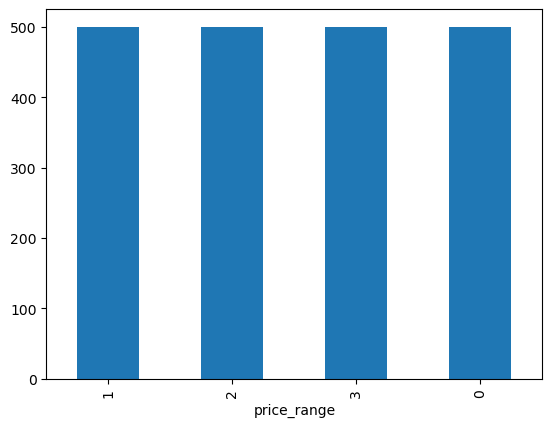

In [12]:
train_df["price_range"].value_counts().plot.bar()

In [21]:
zero_price_df, one_price_df, sec_price_df, third_price_df = create_tier_df(train_df, "price_range",)

In [22]:
zero_price_df.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.0
mean,1116.902000,0.486000,1.550200,0.500000,4.084000,0.518000,31.174000,0.490200,140.552000,4.600000,...,536.408000,1150.27000,785.314000,12.324000,5.682000,10.612000,0.746000,0.524000,0.496000,0.0
std,410.801305,0.500305,0.848941,0.500501,4.183772,0.500176,18.101023,0.288184,36.378319,2.268544,...,372.824164,413.00178,362.755397,4.206949,4.174173,5.397009,0.435734,0.499924,0.500485,0.0
min,503.000000,0.000000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,...,1.000000,500.00000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.0
25%,770.500000,0.000000,0.600000,0.000000,1.000000,0.000000,15.000000,0.200000,108.750000,3.000000,...,229.000000,805.75000,488.750000,9.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.0
50%,1066.000000,0.000000,1.550000,0.500000,3.000000,1.000000,30.000000,0.500000,142.000000,5.000000,...,465.500000,1132.50000,719.500000,12.000000,5.000000,10.000000,1.000000,1.000000,0.000000,0.0
75%,1431.250000,1.000000,2.300000,1.000000,6.000000,1.000000,47.000000,0.700000,173.000000,7.000000,...,776.500000,1452.75000,1037.000000,16.000000,8.250000,15.000000,1.000000,1.000000,1.000000,0.0
max,1994.000000,1.000000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,...,1878.000000,1989.00000,1974.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,0.0


In [23]:
one_price_df.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.0
mean,1228.868000,0.490000,1.488600,0.510000,4.340000,0.524000,32.116000,0.524000,140.510000,4.298000,...,666.892000,1251.908000,1679.490000,12.212000,5.544000,11.362000,0.756000,0.522000,0.504000,1.0
std,438.614528,0.500401,0.814479,0.500401,4.499432,0.499924,18.000739,0.286895,35.678956,2.311684,...,441.351209,433.564352,465.850159,4.226913,4.238868,5.570729,0.429923,0.500016,0.500485,0.0
min,501.000000,0.000000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,...,0.000000,500.000000,387.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.0
25%,843.000000,0.000000,0.600000,0.000000,1.000000,0.000000,16.000000,0.300000,109.000000,2.000000,...,327.250000,878.750000,1354.000000,8.000000,2.000000,7.000000,1.000000,0.000000,0.000000,1.0
50%,1206.000000,0.000000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,...,606.000000,1223.000000,1686.500000,12.000000,5.000000,12.000000,1.000000,1.000000,1.000000,1.0
75%,1596.250000,1.000000,2.200000,1.000000,7.000000,1.000000,47.000000,0.800000,170.000000,6.000000,...,944.250000,1629.000000,2033.750000,16.000000,8.000000,16.000000,1.000000,1.000000,1.000000,1.0
max,1996.000000,1.000000,3.000000,1.000000,18.000000,1.000000,64.000000,1.000000,200.000000,8.000000,...,1914.000000,1998.000000,2811.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,1.0


In [24]:
sec_price_df.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.0
mean,1228.320000,0.486000,1.529800,0.498000,4.49800,0.494000,30.920000,0.490800,143.614000,4.682000,...,632.284000,1234.046000,2582.816000,12.010000,5.714000,10.97200,0.774000,0.470000,0.504000,2.0
std,452.863065,0.500305,0.804404,0.500497,4.34739,0.500465,18.441958,0.286215,34.320326,2.262546,...,445.789232,427.757151,496.211735,4.234355,4.265747,5.43307,0.418658,0.499599,0.500485,0.0
min,501.000000,0.000000,0.500000,0.000000,0.00000,0.000000,2.000000,0.100000,80.000000,1.000000,...,10.000000,508.000000,1185.000000,5.000000,0.000000,2.00000,0.000000,0.000000,0.000000,2.0
25%,816.500000,0.000000,0.700000,0.000000,1.00000,0.000000,15.000000,0.200000,114.000000,3.000000,...,252.500000,862.500000,2292.750000,8.000000,2.000000,6.00000,1.000000,0.000000,0.000000,2.0
50%,1219.500000,0.000000,1.500000,0.000000,3.00000,0.000000,30.000000,0.500000,145.000000,5.000000,...,538.500000,1221.500000,2577.000000,12.000000,5.000000,11.00000,1.000000,0.000000,1.000000,2.0
75%,1635.750000,1.000000,2.200000,1.000000,7.00000,1.000000,48.000000,0.700000,172.000000,7.000000,...,942.750000,1613.250000,2927.000000,16.000000,8.000000,16.00000,1.000000,1.000000,1.000000,2.0
max,1998.000000,1.000000,3.000000,1.000000,18.00000,1.000000,64.000000,1.000000,200.000000,8.000000,...,1960.000000,1997.000000,3916.000000,19.000000,17.000000,20.00000,1.000000,1.000000,1.000000,2.0


In [25]:
third_price_df.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,500.0
mean,1379.984000,0.518000,1.52040,0.530000,4.316000,0.550000,33.976000,0.502000,136.320000,4.502000,...,744.848000,1369.838000,3449.232000,12.680000,6.12800,11.098000,0.770000,0.496000,0.524000,3.0
std,414.992261,0.500176,0.79645,0.499599,4.332399,0.497992,17.930377,0.291901,34.911994,2.297074,...,483.720179,426.823571,393.019923,4.168976,4.71679,5.443129,0.421254,0.500485,0.499924,0.0
min,503.000000,0.000000,0.50000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,...,0.000000,501.000000,2259.000000,5.000000,0.00000,2.000000,0.000000,0.000000,0.000000,3.0
25%,1034.750000,0.000000,0.70000,0.000000,1.000000,0.000000,18.000000,0.200000,104.000000,2.000000,...,341.750000,1041.500000,3207.500000,9.000000,2.00000,7.000000,1.000000,0.000000,0.000000,3.0
50%,1449.500000,1.000000,1.50000,1.000000,3.000000,1.000000,34.500000,0.500000,134.000000,5.000000,...,674.000000,1415.500000,3509.500000,13.000000,5.00000,11.000000,1.000000,0.000000,1.000000,3.0
75%,1733.500000,1.000000,2.20000,1.000000,7.000000,1.000000,49.000000,0.800000,165.000000,7.000000,...,1109.500000,1746.250000,3764.750000,16.000000,10.00000,16.000000,1.000000,1.000000,1.000000,3.0
max,1994.000000,1.000000,3.00000,1.000000,18.000000,1.000000,64.000000,1.000000,200.000000,8.000000,...,1949.000000,1995.000000,3998.000000,19.000000,18.00000,20.000000,1.000000,1.000000,1.000000,3.0


In [29]:
entropy_df = calculate_entropy(train_df)
entropy_df

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
entropy,9.921056,0.999928,4.400807,0.99974,3.642461,0.998666,5.949422,3.277916,6.871219,2.998281,...,9.951111,9.927557,10.500515,3.888598,3.946728,4.2429,0.792537,0.999974,0.999859,2.0


/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_4608/3705246486.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_4608/3705246486.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_4608/3705246486.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_4608/3705246486.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_4608/3705246486.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_4608/3705246486.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_4608/3705246486.p

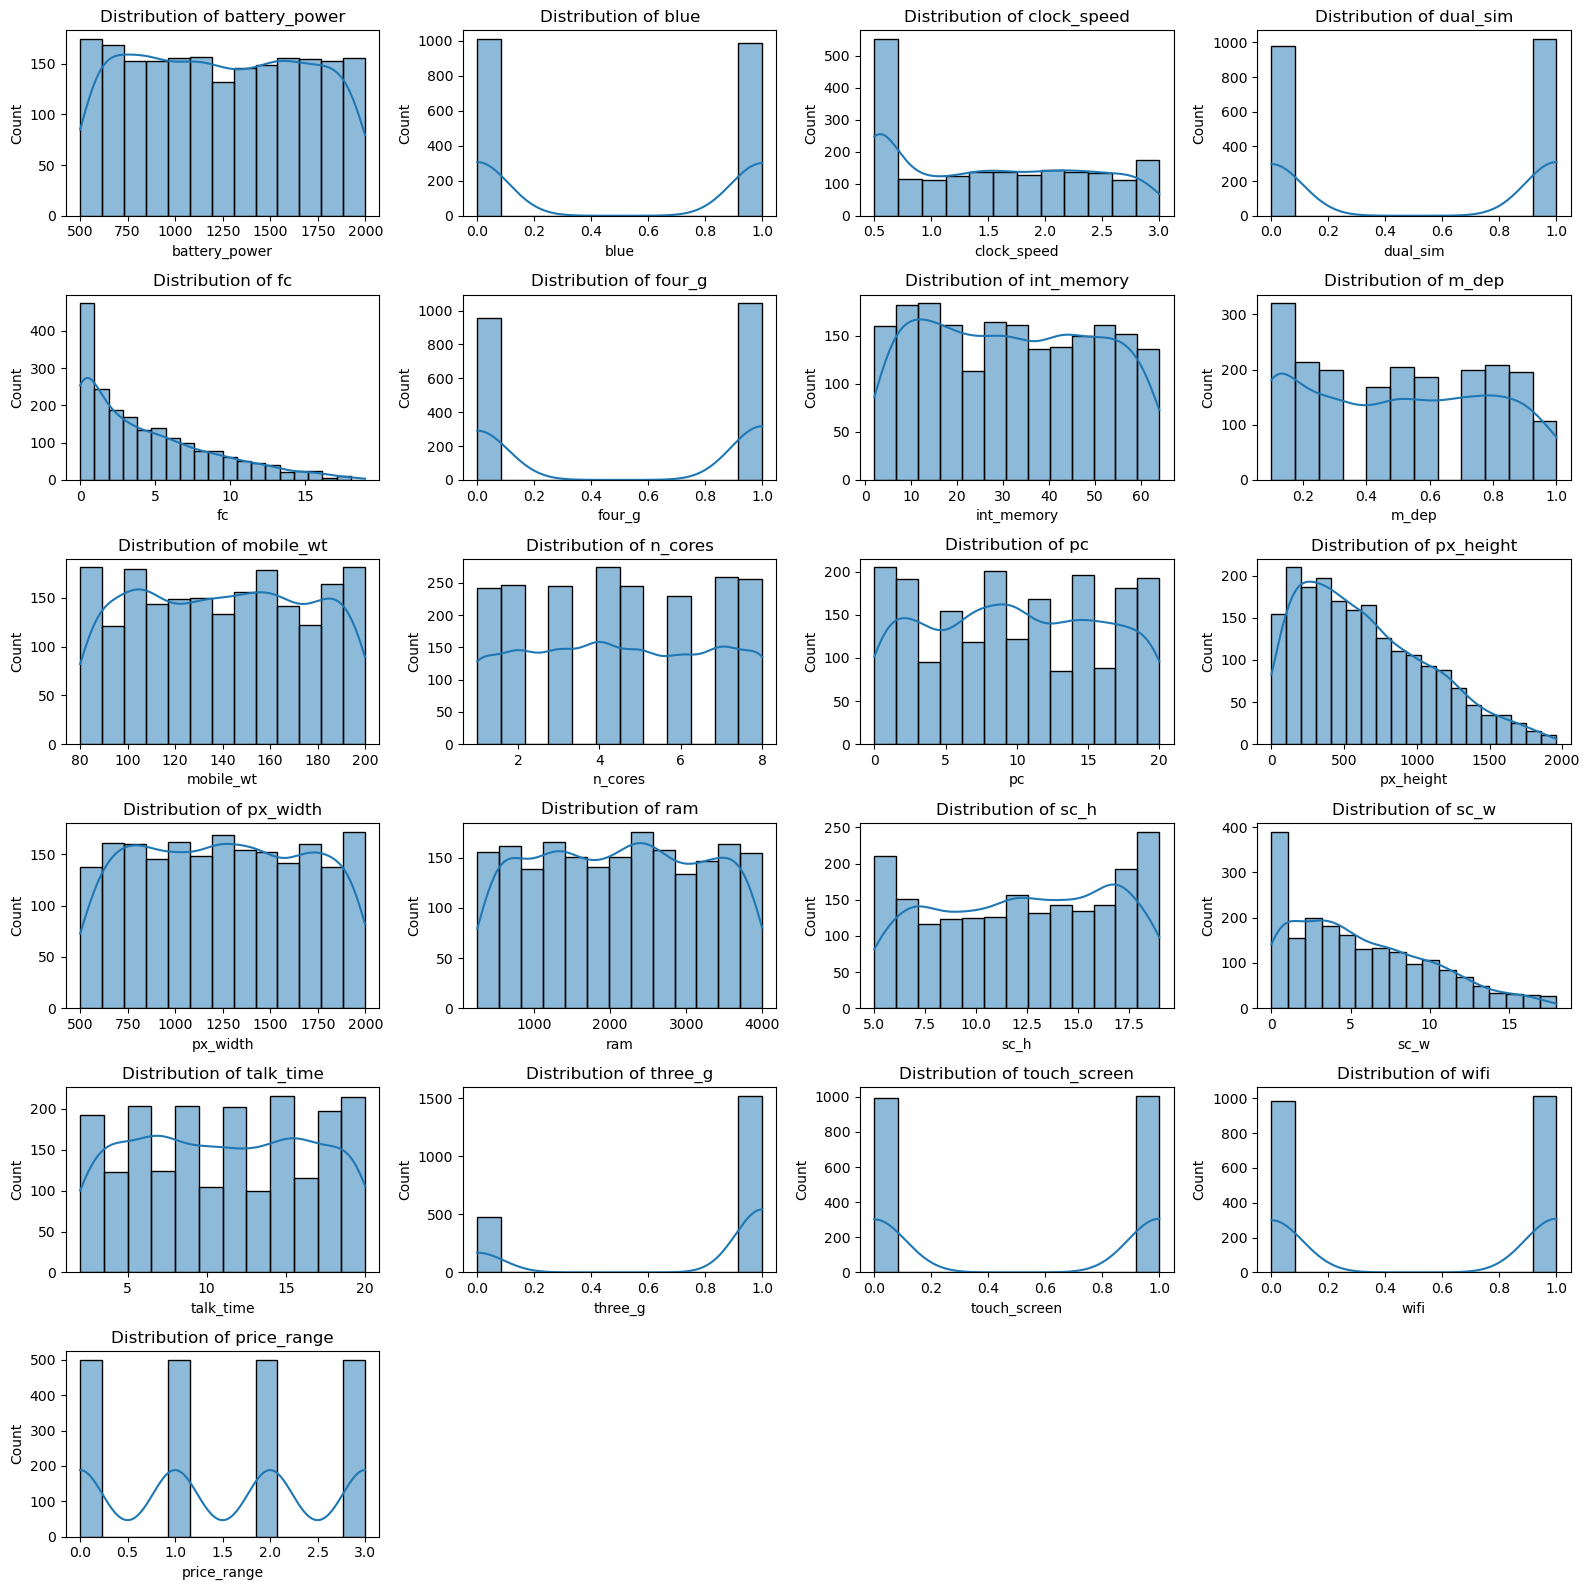

In [41]:
plt.figure(figsize=(16,16))
total_cols = len(train_df.columns)
rows = (total_cols + 3)//4

for idx, col in enumerate(train_df.columns):
  plt.subplot(rows,4,idx+1)
  sns.histplot(train_df[col], kde=True)
  plt.title(f"Distribution of {col}")
  plt.tight_layout()
  plt.plot()

/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_4608/1523807570.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_4608/1523807570.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_4608/1523807570.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_4608/1523807570.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_4608/1523807570.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_4608/1523807570.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_4608/1523807570.p

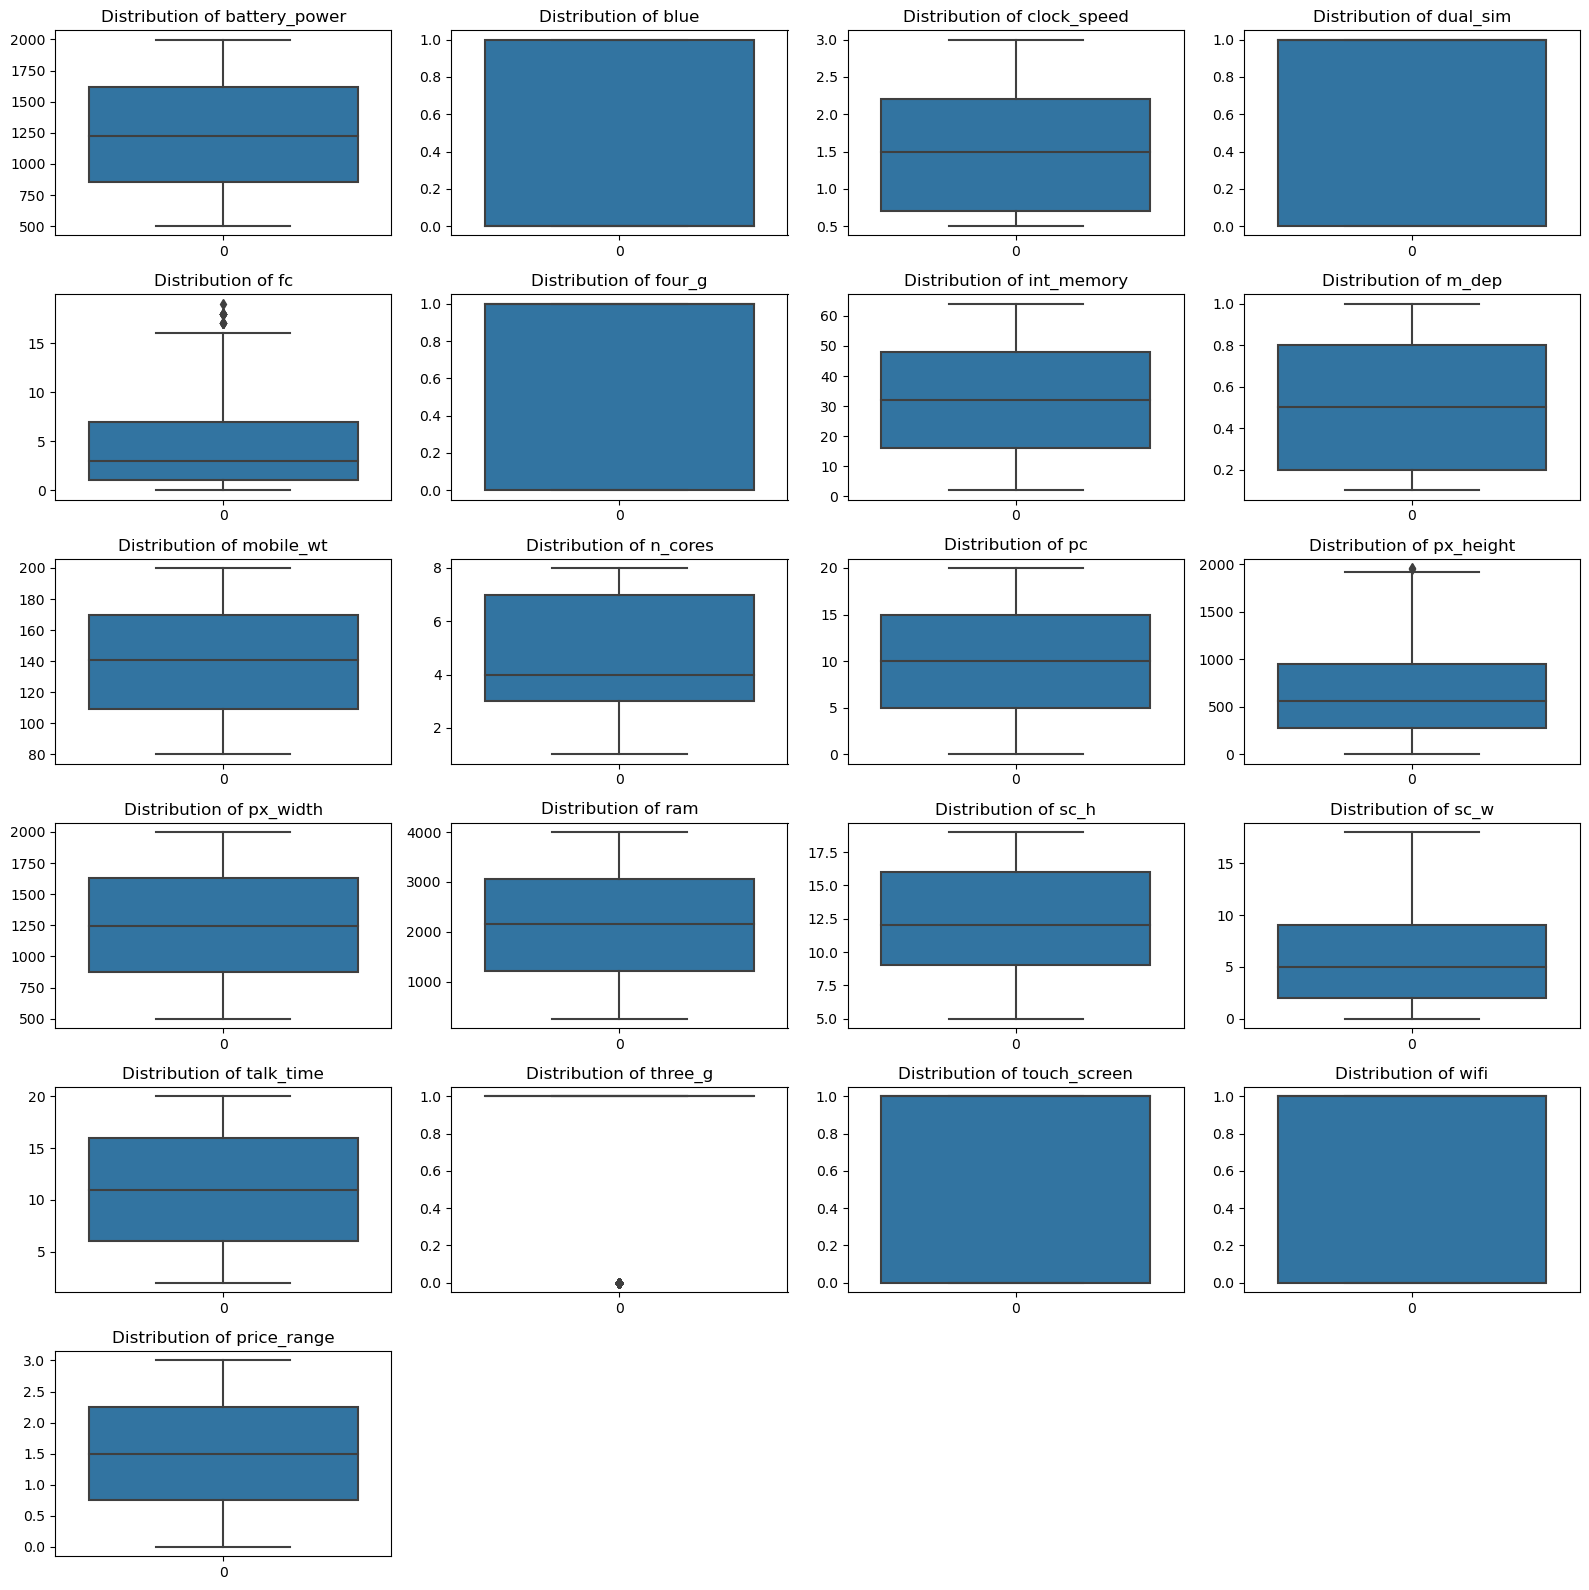

In [42]:
plt.figure(figsize=(16,16))
total_cols = len(train_df.columns)
rows = (total_cols + 3)//4

for idx, col in enumerate(train_df.columns):
  plt.subplot(rows,4,idx+1)
  sns.boxplot(train_df[col])
  plt.title(f"Distribution of {col}")
  plt.tight_layout()
  plt.plot()

## Test for base model performance

In [36]:
def f1_multiclass(y_true, y_pred):
  return f1_score(y_true, y_pred, average='macro')

# evaluate a model
def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  # define the model evaluation metric
  metric = make_scorer(f1_multiclass)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

last_ix = len(train_df.columns)-1
X, y = train_df.drop(train_df.columns[last_ix], axis=1), train_df[train_df.columns[last_ix]]
# summarize the loaded dataset
print(X.shape, y.shape, Counter(y))
# define the reference model
model = DummyClassifier(strategy='uniform')
# evaluate the model
scores = evaluate_model(X, y, model)
# summarize performance
print('Mean F1: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

(2000, 20) (2000,) Counter({1: 500, 2: 500, 3: 500, 0: 500})


Mean F1: 0.245 (0.032)


#### Our Models should perform better than the F1-Score of 0.245